# Air Quality Prediction Experiment

This notebook combines PWWB, AirNow, and HRRR datasets for air quality prediction using TF-Keras.
Changes:
- A lot of hard coding things like sensor names
- Have another script handle ALL preprocessing; we just load the numpy files and stack them here
- Removed scaled target data for simplicity

Differences from original test:
- Last notebook had overfitting issue; adding dropout rate of 50%.
- Epochs 150 -> 100. Will increase if loss is trending well.
- Reduced target sensors that were in the periphery outside of the LA metropolitan area

# Load data

In [1]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

EXPERIMENT_NAME = "January 2022 to December 2024"
EXPERIMENT_DESCRIPTION = "January 2025 fire period with PWWB, Airnow, and HRRR data."
EXPERIMENT_ID = "two_years_pwwb_airnow_hrrr"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"
TRAIN_SPLIT = 0.80  # 70% for training, 10% for val (will split later), leaving 20% for test.

# Model parameters
EPOCHS = 100
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01

#all_channel_names = ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25', 'HRRR_COLMD']
all_channel_names = ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25']

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: January 2022 to December 2024
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date Range: 2022-12-01-00 to 2024-12-01-00
Train/Test Split: 80%/20% (temporal)


In [2]:
# load: X_train_scaled, X_test_scaled (combined from np files), y_train, y_test.
test_files = ["MAIAC_AOD_X_test.npy", "TROPOMI_NO2_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "AirNow_PM25_X_test.npy"]
train_files = ["MAIAC_AOD_X_train.npy", "TROPOMI_NO2_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "AirNow_PM25_X_train.npy"]
X_train_scaled = np.stack([np.load(f"final_input_data/{file}") for file in train_files], axis=-1)
X_test_scaled = np.stack([np.load(f"final_input_data/{file}") for file in test_files], axis=-1)
Y_train = np.load("final_input_data/Y_train.npy")
Y_test = np.load("final_input_data/Y_test.npy")

In [3]:
# Debug cell to check channel names and data shapes
print("=== DEBUGGING CHANNEL INFORMATION ===")
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Number of channels in data: {X_train_scaled.shape[4]}")
print(f"Number of channel names provided: {len(all_channel_names)}")
print(f"Channel names length matches data channels: {len(all_channel_names) == X_train_scaled.shape[4]}")
print()

print("Channel names provided:")
for i, name in enumerate(all_channel_names):
    print(f"  {i}: {name}")
print()

print("What the visualization function will use:")
n_channels = X_train_scaled.shape[4]
if all_channel_names is None or len(all_channel_names) != n_channels:
    effective_channel_names = [f"Channel {i}" for i in range(n_channels)]
    print("  Using GENERIC channel names (this is the problem!):")
else:
    effective_channel_names = all_channel_names
    print("  Using PROVIDED channel names:")

for i, name in enumerate(effective_channel_names):
    print(f"  {i}: {name}")
print()

print("=== DATA SAMPLE CHECK ===")
# Check what's actually in the first few channels
sample_idx = 42  # Use same sample as visualization
for c in range(min(3, n_channels)):  # Check first 3 channels
    data = X_train_scaled[sample_idx, 0, :, :, c]  # First frame
    print(f"Channel {c} ({effective_channel_names[c] if c < len(effective_channel_names) else 'Unknown'}):")
    print(f"  Min: {data.min():.6f}, Max: {data.max():.6f}, Mean: {data.mean():.6f}")
    print()

=== DEBUGGING CHANNEL INFORMATION ===
Experiment name: January 2022 to December 2024
X_train_scaled shape: (14032, 5, 40, 40, 5)
Number of channels in data: 5
Number of channel names provided: 5
Channel names length matches data channels: True

Channel names provided:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25

What the visualization function will use:
  Using PROVIDED channel names:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25

=== DATA SAMPLE CHECK ===
Channel 0 (MAIAC_AOD):
  Min: -1.082072, Max: 1.538770, Mean: -0.268708

Channel 1 (TROPOMI_NO2):
  Min: -0.564229, Max: 0.134721, Mean: -0.139519

Channel 2 (METAR_Wind_U):
  Min: -2.473276, Max: -2.212808, Mean: -2.315924



Visualizing data for January 2022 to December 2024...


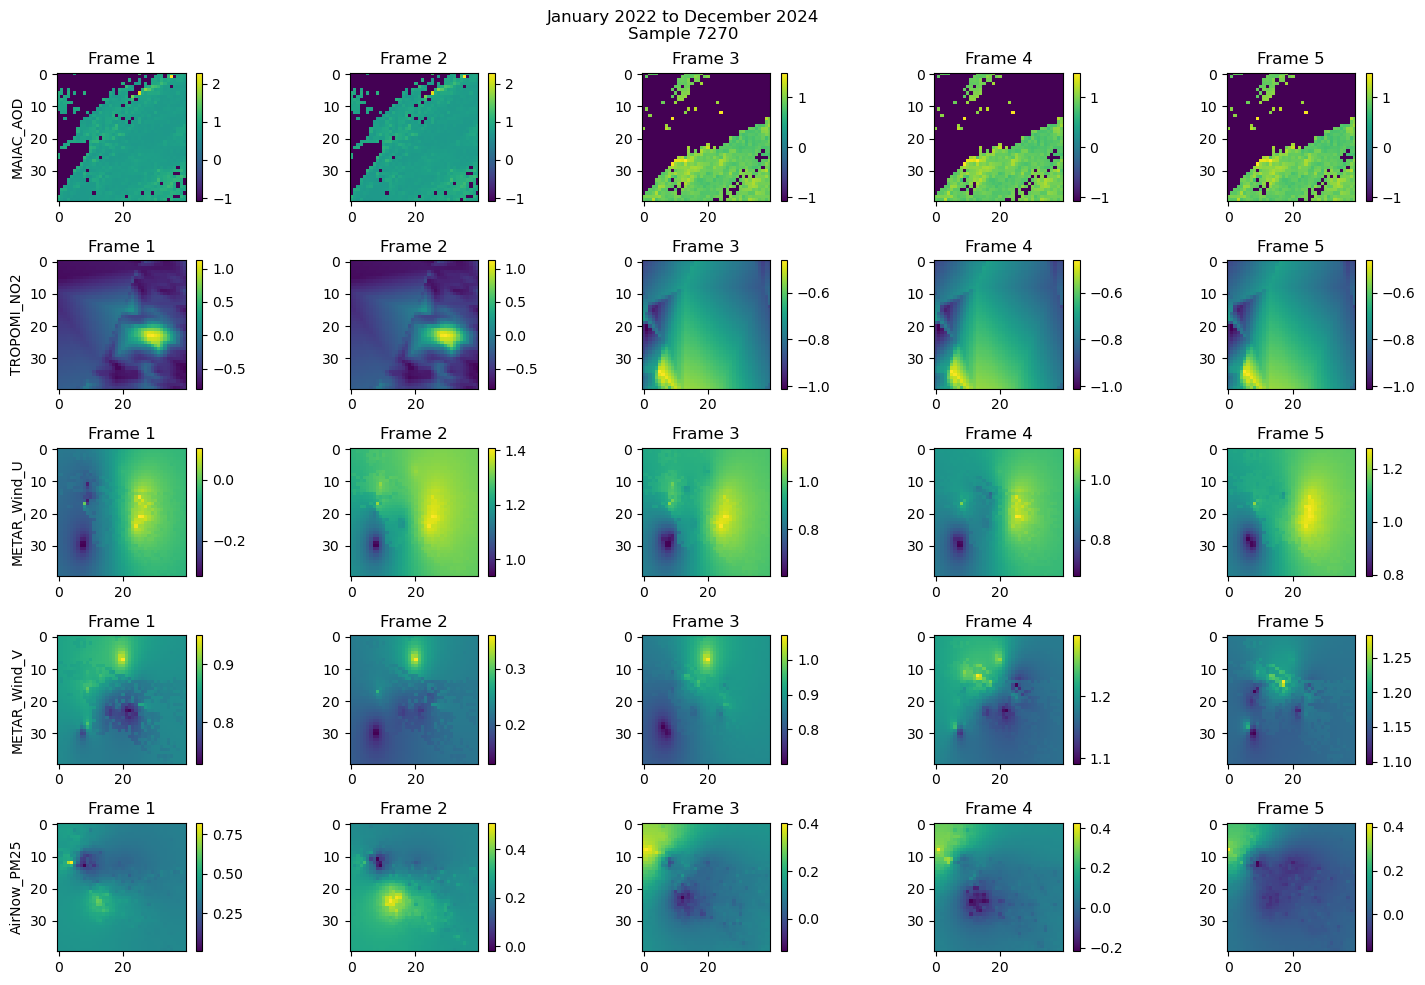

Target values: [11.7 16.2 13.5  8.   9.3  8.6  0.   7.7]


In [4]:
# Function to visualize data from experiment
np.random.seed(42)
def visualize_experiment_data(X, Y, channel_names=None, sample_idx=None, experiment_name="Experiment"):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        channel_name = channel_names[c] if c < len(channel_names) else f"Channel {c}"
        
        for f in range(n_frames):
            ax = axes[c, f]
            data = X[sample_idx, f, :, :, c]
            
            im = ax.imshow(data)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_name)
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"{experiment_name}\nSample {sample_idx}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if Y is not None:
        print(f"Target values: {Y[sample_idx]}")

# Run the visualization  
print(f"Visualizing data for {EXPERIMENT_NAME}...")
visualize_experiment_data(X_train_scaled, Y_train, channel_names=all_channel_names, experiment_name=EXPERIMENT_NAME)

# Tensorflow Model Definition

In [5]:
input_shape = X_train_scaled.shape[1:]  # (timesteps, height, width, channels)
output_size = Y_train.shape[1]

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=input_shape)
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Dropout(rate=0.5))

seq.add(Dense(output_size*n_frames, activation='relu'))

seq.add(Reshape(n_frames, output_size))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

2025-06-01 21:18:06.496528: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 21:18:06.572607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748837886.586152   12697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748837886.590764   12697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-01 21:18:06.649514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │        10,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        64,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,159 (531.87 KB)

 Trainable params: 136,159 (531.87 KB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [7]:
print(f"\n==== Training Model for {EXPERIMENT_NAME} ====")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Target data shape: {Y_train.shape}")

history = seq.fit(X_train_scaled, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2)

print(f"\n✓ Model training completed for {EXPERIMENT_NAME}!")


==== Training Model for January 2022 to December 2024 ====
Training data shape: (14032, 5, 40, 40, 5)
Target data shape: (14032, 8)
Epoch 1/100


I0000 00:00:1748837893.754709   12806 service.cc:148] XLA service 0x71422c0f08f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748837893.754736   12806 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-06-01 21:18:13.829019: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748837894.122275   12806 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-06-01 21:18:14.664328: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

  5/702 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 8.8746

I0000 00:00:1748837896.660951   12806 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


701/702 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.4216

2025-06-01 21:18:36.417380: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[9,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[9,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-01 21:18:36.537884: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[9,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[9,5,40,40]{3,2,1,0}, f32[15,5,3,3]{3,2,1,0}, f32[15]{0}, f32[9,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.4207

2025-06-01 21:18:40.650502: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,5,40,40]{3,2,1,0}, f32[15,5,3,3]{3,2,1,0}, f32[15]{0}, f32[7,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-01 21:18:40.693680: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[7,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[7,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[7,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01,

702/702 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - loss: 3.4197 - val_loss: 2.5402
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 2.1673 - val_loss: 2.3767
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.9399 - val_loss: 2.0933
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.7884 - val_loss: 2.1041
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.7164 - val_loss: 2.0844
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.6861 - val_loss: 2.1070
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.6360 - val_loss: 2.0327
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.6334 - val_loss: 2.0731
Epoch 9/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.6062 - val_loss: 2.0411
Epoch 10/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.6328 - val_loss: 2.0535
Epoch 11/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 1.5349 - val_loss: 2.0575
Epoch 12/100
702/702 ━━━━━━━━━━

# Model Evaluation


Evaluating model for January 2022 to December 2024...


2025-06-01 21:54:48.771386: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,5,40,40]{3,2,1,0}, f32[15,5,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-06-01 21:54:48.825724: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-


Final Results for January 2022 to December 2024 (Real PM2.5 Scale):
Mean Absolute Error: 2.0853 μg/m³
Root Mean Squared Error: 3.3939 μg/m³
R² Score: 0.6952


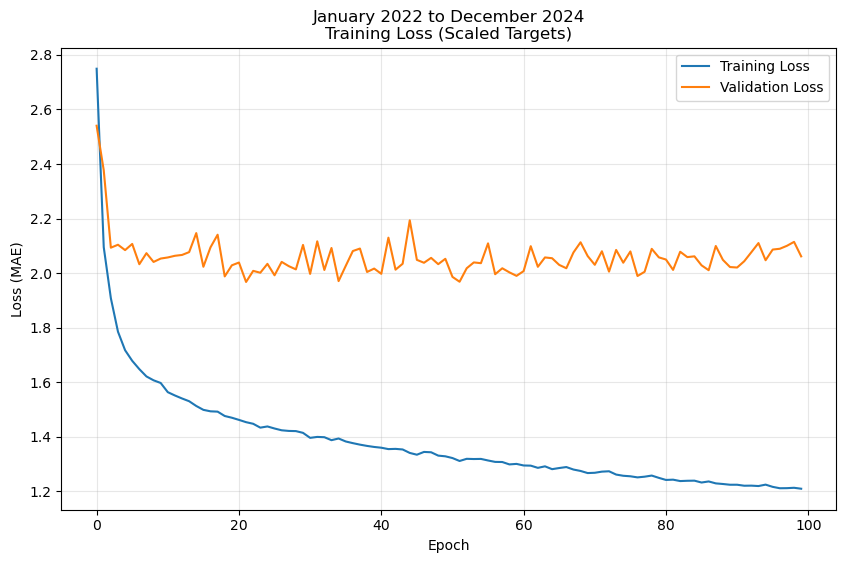


✓ Evaluation completed for January 2022 to December 2024
Results saved to: experiment_output/two_years_pwwb_airnow_hrrr/results


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Evaluate model
print(f"\nEvaluating model for {EXPERIMENT_NAME}...")
y_pred = seq.predict(X_test_scaled, verbose=0)

# Calculate metrics on real scale
mae_real = mean_absolute_error(Y_test, y_pred)
rmse_real = np.sqrt(mean_squared_error(Y_test, y_pred))
r2_real = r2_score(Y_test, y_pred)

print(f"\nFinal Results for {EXPERIMENT_NAME} (Real PM2.5 Scale):")
print(f"Mean Absolute Error: {mae_real:.4f} μg/m³")
print(f"Root Mean Squared Error: {rmse_real:.4f} μg/m³")
print(f"R² Score: {r2_real:.4f}")


# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{EXPERIMENT_NAME}\nTraining Loss (Scaled Targets)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results (save both scaled and real versions)
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# Save real scale results for analysis
np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)
np.save(os.path.join(results_dir, "Y_test.npy"), Y_test)

# Save model and scaler
seq.save(os.path.join(results_dir, "model.keras"))

print(f"\n✓ Evaluation completed for {EXPERIMENT_NAME}")
print(f"Results saved to: {results_dir}")

# Detailed Analysis

In [9]:
print(f"\nDetailed analysis for {EXPERIMENT_NAME}:")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Temporal split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}%")
print(f"Total sensors: {Y_test.shape[1]}")


Detailed analysis for January 2022 to December 2024:
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date range: 2022-12-01-00 to 2024-12-01-00
Temporal split: 80%/20%
Total sensors: 8


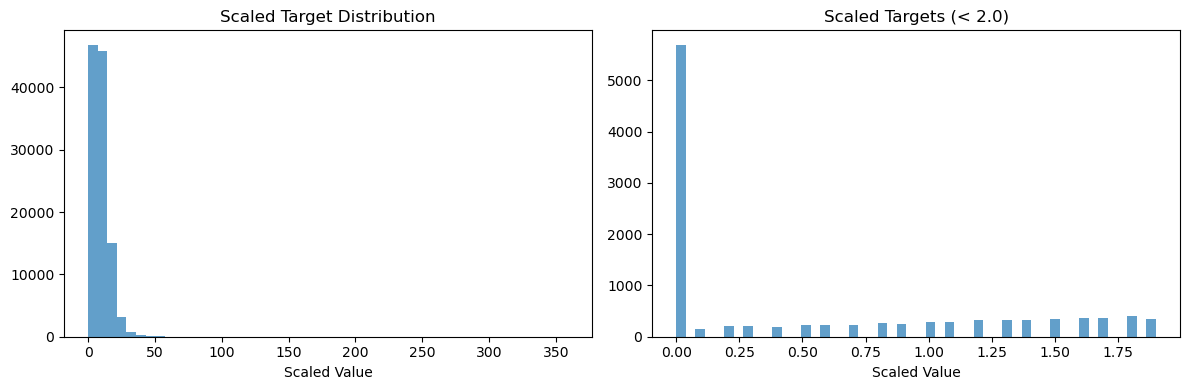

Percentage of targets > 5.0: 73.3%
Percentage of targets > 2.0: 89.8%


In [10]:
import matplotlib.pyplot as plt

# Check target distribution
Y_flat = Y_train.flatten()
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(Y_flat, bins=50, alpha=0.7)
plt.title('Scaled Target Distribution')
plt.xlabel('Scaled Value')

plt.subplot(1, 2, 2)
plt.hist(Y_flat[Y_flat < 2], bins=50, alpha=0.7)  # Zoom in on normal range
plt.title('Scaled Targets (< 2.0)')
plt.xlabel('Scaled Value')

plt.tight_layout()
plt.show()

print(f"Percentage of targets > 5.0: {(Y_flat > 5.0).mean()*100:.1f}%")
print(f"Percentage of targets > 2.0: {(Y_flat > 2.0).mean()*100:.1f}%")

In [11]:
print("Original targets:")
print(f"Y_train range: {Y_train.min():.3f} to {Y_train.max():.3f}")

Original targets:
Y_train range: 0.000 to 358.900



Sensors in January 2022 to December 2024: ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']

1. Plotting prediction comparison...


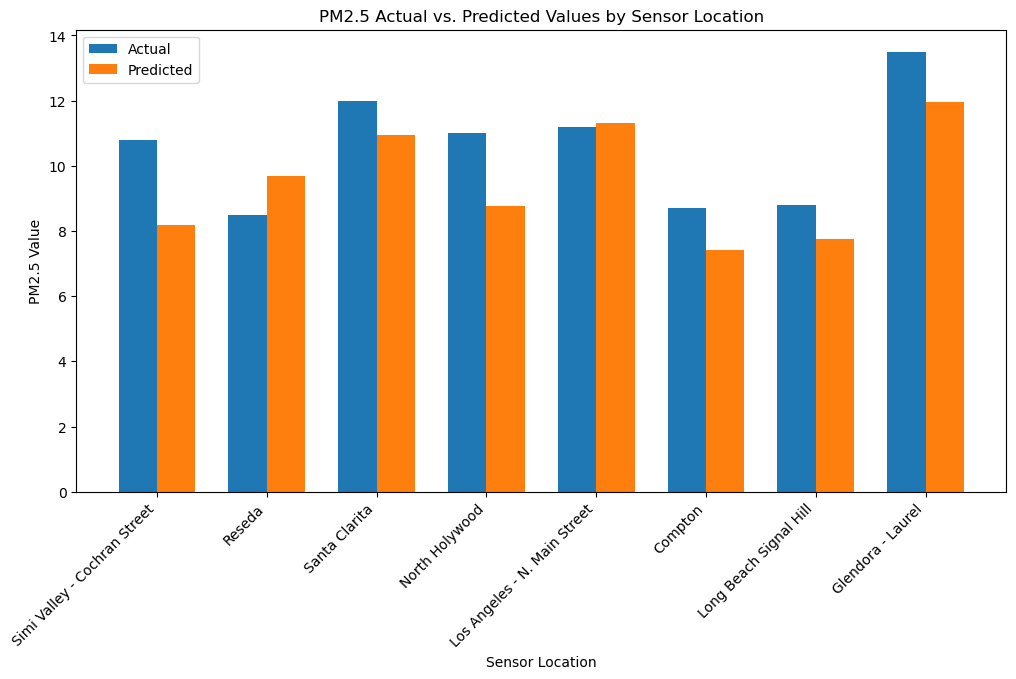


2. Plotting scatter comparison...


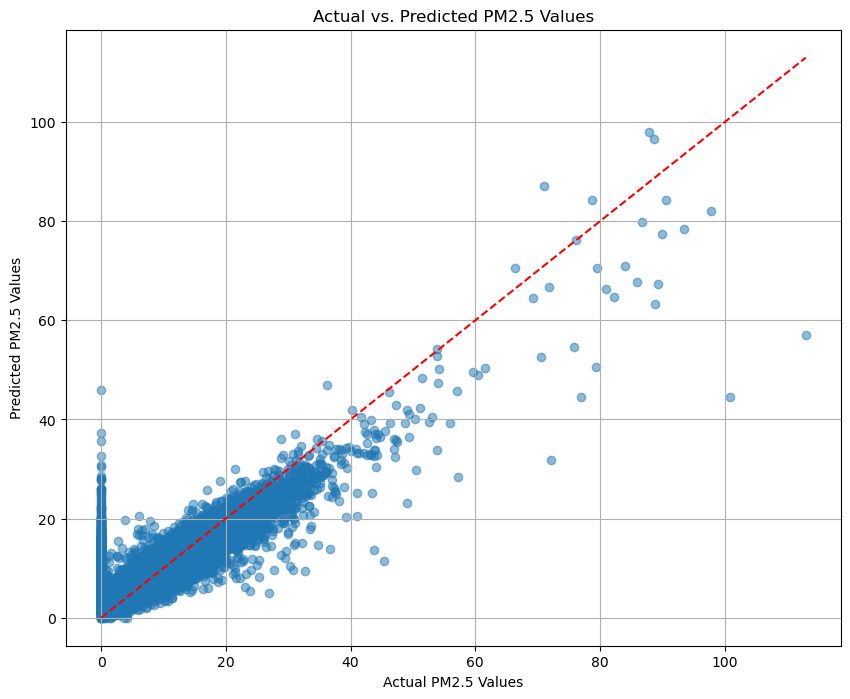


3. Plotting error by sensor...


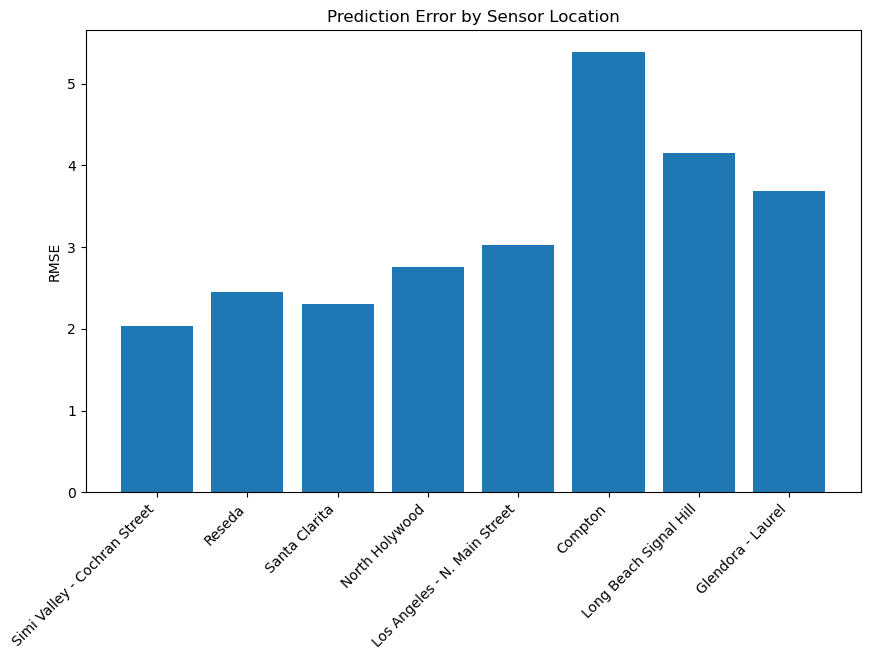


4. Plotting time series comparison...


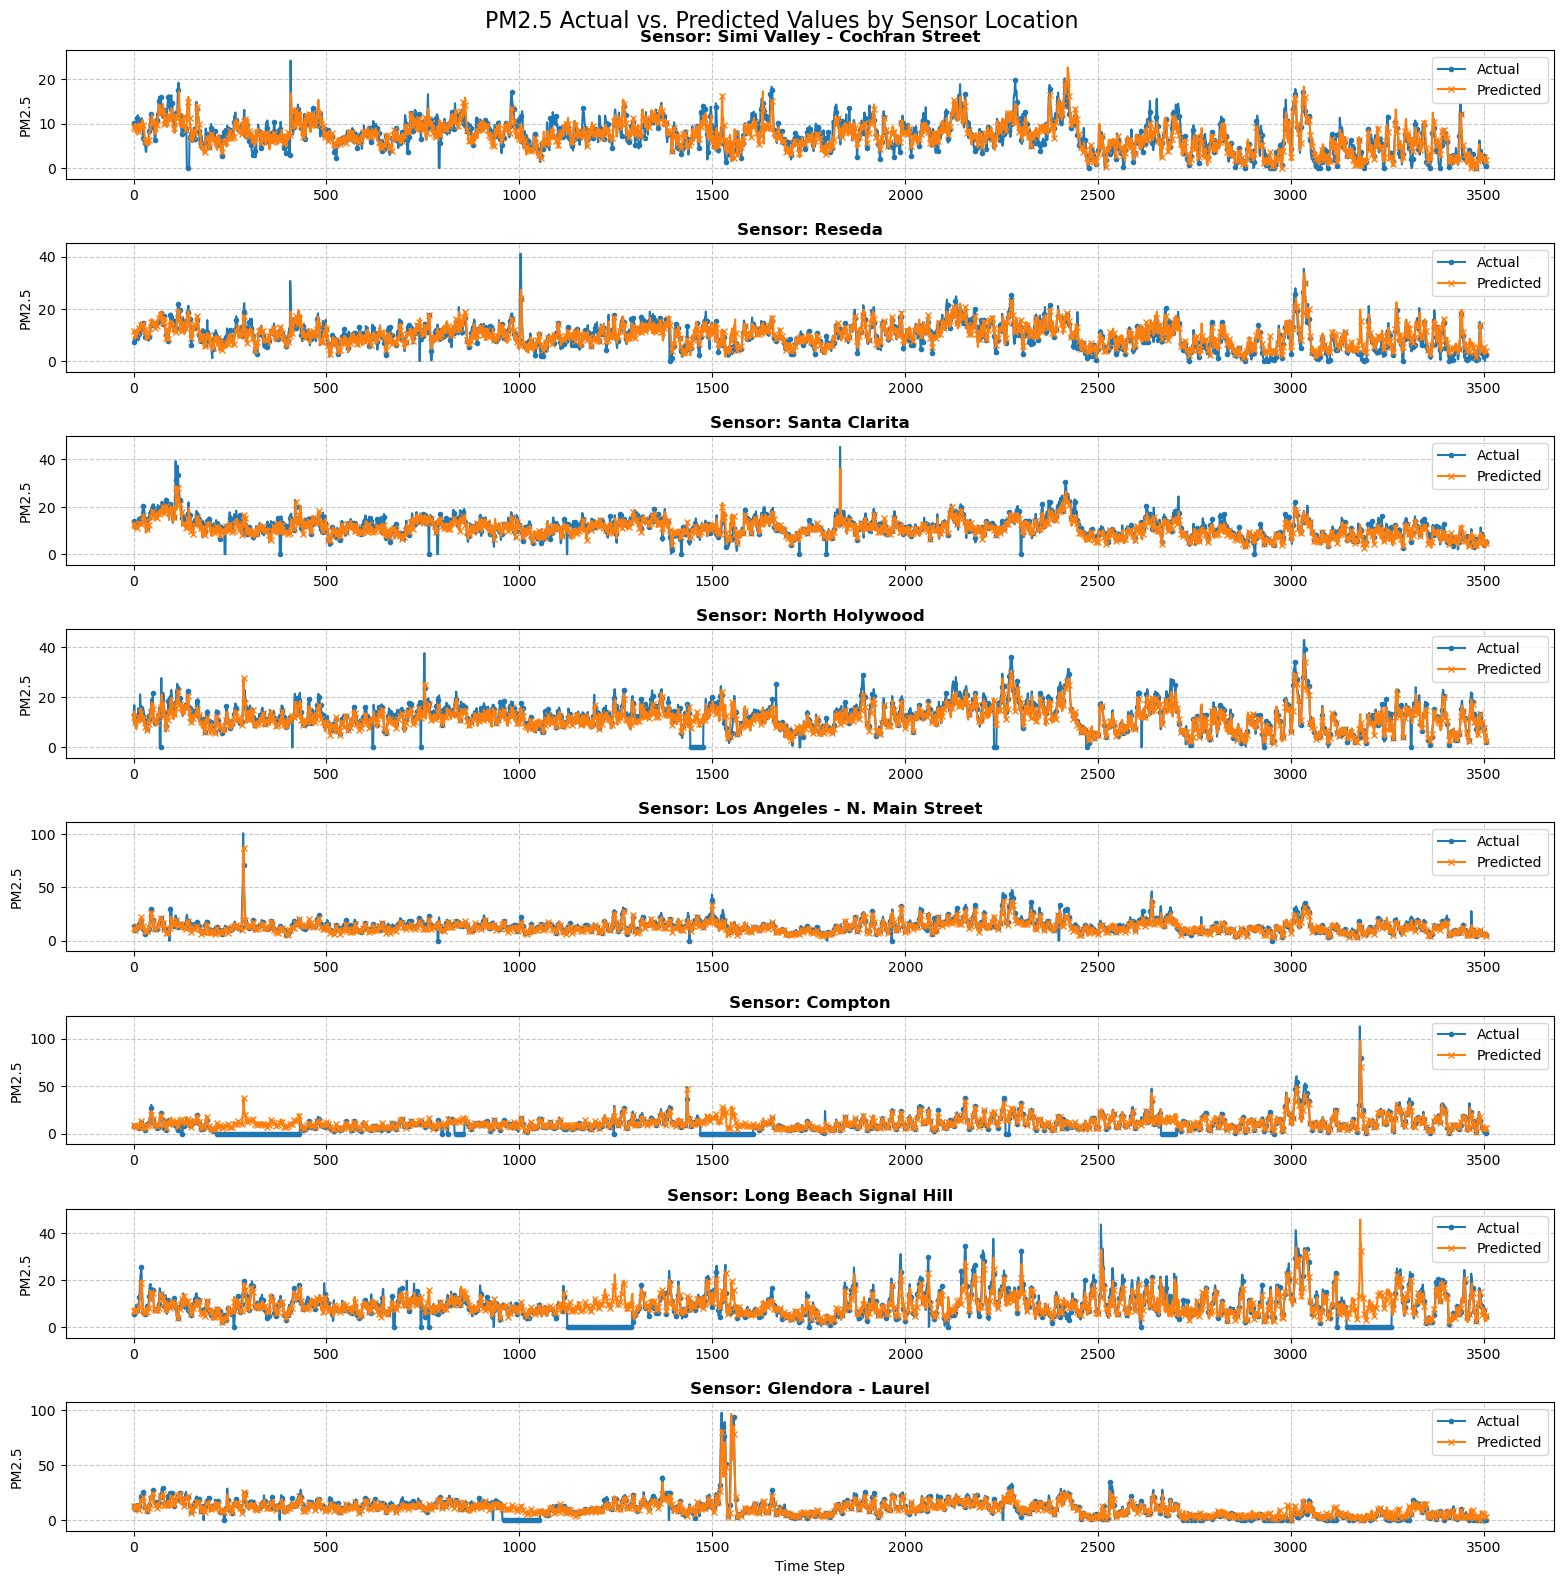


5. Plotting time series with shifted predictions...


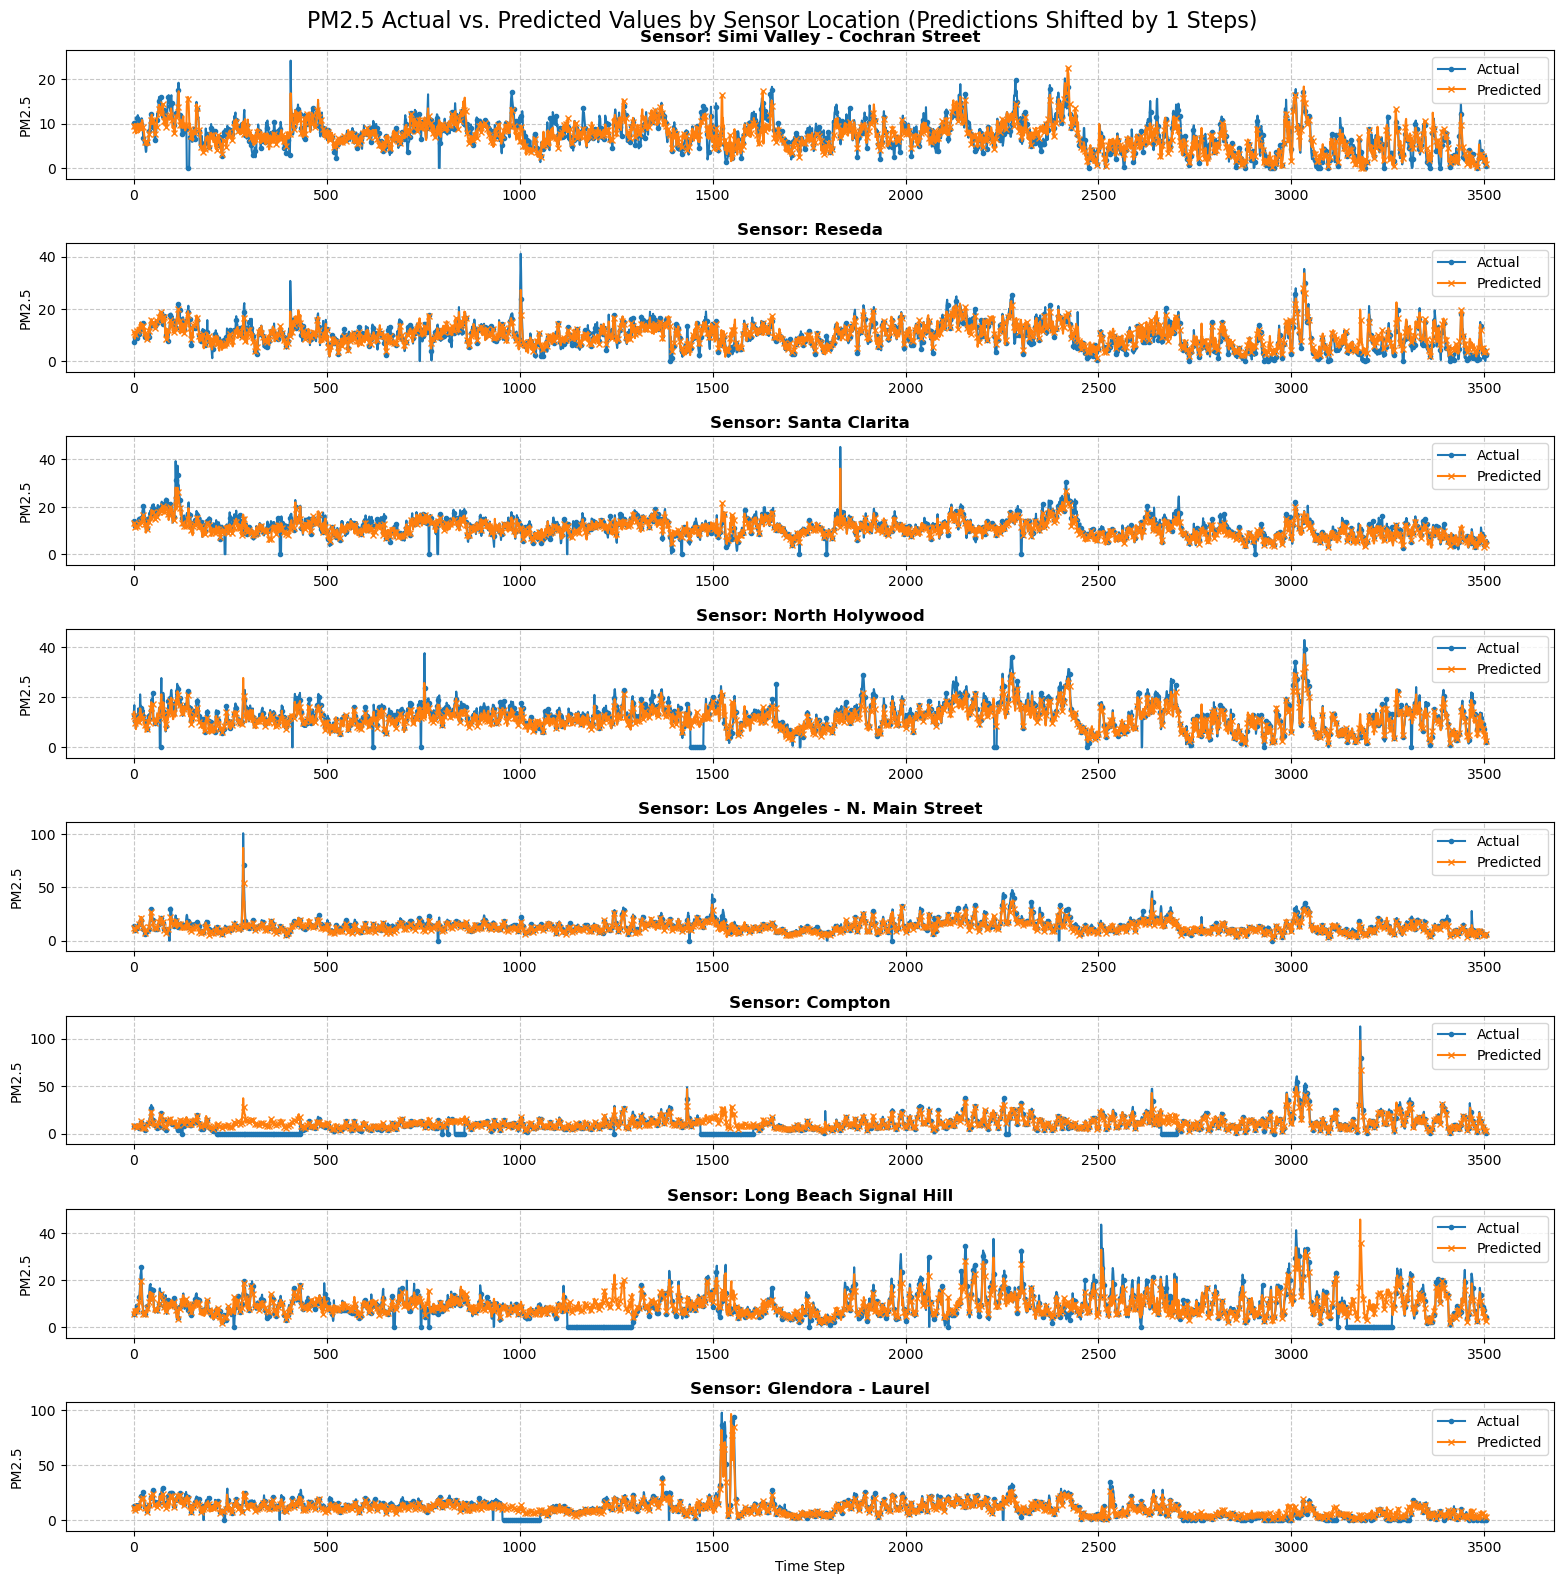


6. Printing detailed metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 3.39
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 32.22%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 1.72
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 16.38%

Frame 2 (Hour 2) All Locations - Raw RMSE: 1.63
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 15.40%

Frame 3 (Hour 3) All Locations - Raw RMSE: 1.93
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 18.62%

Frame 4 (Hour 4) All Locations - Raw RMSE: 1.73
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 17.75%

Frame 5 (Hour 5) All Locations - Raw RMSE: 1.30
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 13.27%

Frame 6 (Hour 6) All Locations - Raw RMSE: 0.89
Frame 6 (Hour 6) All L

In [12]:
import sys
sys.path.append("../..")

from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Get sensor names
sensor_names = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 
    'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel'
]

print(f"\nSensors in {EXPERIMENT_NAME}: {sensor_names}")

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred, Y_test, sensor_names, sample_idx=8)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred, Y_test)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred, Y_test, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred, Y_test, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred, Y_test, sensor_names, shift_pred=1)

print("\n6. Printing detailed metrics...")
print_metrics(y_pred, Y_test, sensor_names)